# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## 1. Business Understanding

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

##### Questions to ask?

1. What are the most successful offers? Why there are unsuccessful offers?
2. Average Age of the people who used the offer BOGO?
3. Average income of the people who used the discount offer?
4. Machine learning model that predicts whether or not someone will respond to an offer.

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## 2. Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer (Missing values are encoded as 118)
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description **(transaction, offer received, offer viewed, offer completed)**
* person (str) - customer id
* time (int) - time in hours since start of test (hours after start of test). The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

*Note for the value in transcript dict:*
1. For transaction -> amount:
2. For offer received -> offer id:   
3. For offer viewed -> offer id: 
4. offer completed -> offer id: , reward:

## 3. Data Cleaning and Preparation

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.



In [1]:
# Read libraries and DataFrames

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve, auc

% matplotlib inline

# # read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Check portfolio dataset

In [2]:
#portfolio.shape #(10, 6)
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Observations:
1. It would be better to sort the columns so that the **id** comes first.
2. Rename id to offer_id.
3. **channels** list can be transferred to columns so that every variant is having column with values of 0 and 1. 0 indicates that it doesn't exists and 1 to indicate that it exists.


In [3]:
# Rename id to offer_id
portfolio.rename({'id':'offer_id'}, axis=1, inplace=True)

In [4]:
# Sort columns.
portfolio = portfolio[['offer_id', 'offer_type', 'reward', 'difficulty', 'duration', 'channels']]

In [5]:
# Split columns
# Create columns from the values of channels, use 0 and 1 as indicators.
split_df = portfolio['channels'].str.join(sep=',').str.get_dummies(sep=',')

In [6]:
# Concat the split and portfolio and drop Channels column.

portfolio = pd.concat([portfolio, split_df], axis=1)
portfolio = portfolio.drop(['channels'], axis=1)

In [7]:
# Check
portfolio.head(10)

,offer_id,offer_type,reward,difficulty,duration,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,7,7,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10,10,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,discount,2,10,7,1,1,0,1


_______

## Check Profile dataset

In [8]:
# Check shape and head of the dataset.

#profile.shape #(17000, 5)
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
# Check data types for each column and missing values.

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Observations:
1. Rename **id** to be **customer_id**
1. It would be better to sort the columns so that the **customer_id** comes first.
2. **Became_member_on** would be better to change it to datetime format instead of int.
3. Decide for strategy to fill in the *missing values* in the dataset.



- **Note 1**: We have 2175 missing values from columns **gender** and **income**.
- **Note 2**: 118 as age indicates missing values.

In [10]:
# Rename id to customer_id
profile.rename({'id':'customer_id'}, axis=1, inplace=True)

In [11]:
# Sort columns.
profile = profile[['customer_id', 'age', 'gender', 'income', 'became_member_on']]

In [12]:
profile.head(5)

,customer_id,age,gender,income,became_member_on
0,68be06ca386d4c31939f3a4f0e3dd783,118,None,NaN,20170212
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,20170715
2,38fe809add3b4fcf9315a9694bb96ff5,118,None,NaN,20180712
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,20170509
4,a03223e636434f42ac4c3df47e8bac43,118,None,NaN,20170804


In [13]:
# Convert became_member_on to datetime format.

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [14]:
# Check the datatypes.

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
customer_id         17000 non-null object
age                 17000 non-null int64
gender              14825 non-null object
income              14825 non-null float64
became_member_on    17000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


In [15]:
# Get how many profiles are having 118 as values in age
profile.query('age == 118').shape[0]

2175

**Note 3**: Similarly age has 2175 missing values.

In [16]:
df_118_age = profile[profile.age == 118]

In [17]:
df_118_age.isnull().sum()

customer_id            0
age                    0
gender              2175
income              2175
became_member_on       0
dtype: int64

In [18]:
#df_118_age['gender'].value_counts() # Empty series
df_118_age['income'].value_counts()  # Also Empty series.

Series([], Name: income, dtype: int64)

Observation & Decision
1. All the Age column in the DataFrame that has **missing age values (118)** has also missing **income** and **gender** values.

- Therfore: These values can be removed from the profile dataframe, as it leaves us with became_member_on and id and those 2 values are not necessary to answer our questions.

In [19]:
profile = profile[profile.age != 118]

In [20]:
# Check 1
profile.shape

(14825, 5)

In [21]:
# Check 2
profile.isnull().sum()

customer_id         0
age                 0
gender              0
income              0
became_member_on    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7fdd09128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc7fdca51d0>]], dtype=object)

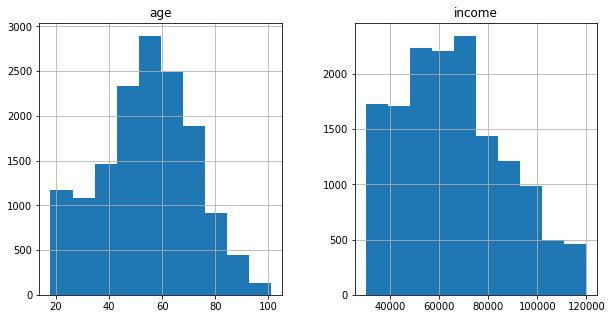

In [22]:
# Detect outliers in age and income column.

profile.hist(figsize=(10, 5))

Text(0,0.5,'Gender')

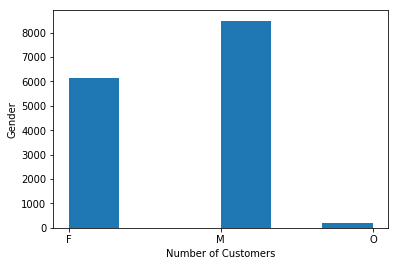

In [23]:
# We can plot here the distribution of the customer gender.

plt.hist(profile.gender, bins = 6)
plt.xlabel('Number of Customers')
plt.ylabel('Gender')

In [24]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [25]:
# Confirm mean is bigger than the median in income column.

profile['income'].mean() > profile['income'].median()

True

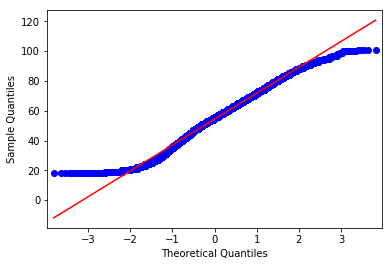

In [26]:
# Confirm if age is normally distibuted 

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

data = profile['age']

qqplot(data, line='s')
pyplot.show()

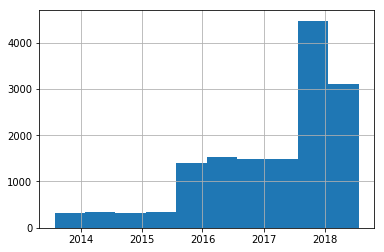

In [27]:
profile.became_member_on.hist()

In [28]:
profile.head(5)

,customer_id,age,gender,income,became_member_on
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09
5,e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018-04-26
8,389bc3fa690240e798340f5a15918d5c,65,M,53000.0,2018-02-09
12,2eeac8d8feae4a8cad5a6af0499a211d,58,M,51000.0,2017-11-11


In [29]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
customer_id         14825 non-null object
age                 14825 non-null int64
gender              14825 non-null object
income              14825 non-null float64
became_member_on    14825 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


Observations:
1. It seems that the age is almost normally distributed.
2. The Income is slightly right skewed.
3. The customer dataset has higher number of males than females.
4. It seems that the busiest dates for signing up is from **Q3 2017 up to Q2 2018**.


* Males: 8484
* Females: 6129

----------------------

## Check Transcript dataset

##### There are various types of Events.
- Offer recieved -> It gives value of **offer_id**
- Offer viewed -> It gives value of **offer_id**
- Offer completed -> It gives value **offer_id & Reward:** *Money starbucks gained*
- Transaction -> It gives value **Money spent by user** 


Hint: time in hours since start of test (hours after start of test). The data begins at time t=0
-  This can give us an opportunity to know how long did it take for some customer to "view offer" - "complete offer" etc.

In [30]:
# Read the data 

transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [32]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [33]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Observation: 
    
1. There are no any missing data in the transcript dataset.
2. Change **person** name to **customer_id**.
3. Get **offer_id**, **Reward** from value in seperate columns.
4. Unify the name *offer_id* and *offer id* in value to be **offer_id**.
5. Transfer time (hours) to days.

In [34]:
# Change person name to customer_id.
transcript.rename({'person':'customer_id'}, axis=1, inplace=True)

In [35]:
# Get the offer_id and reward in seperate columns
# Verified to be correct.
transcript = pd.concat([transcript['customer_id'], transcript['time'], transcript['event'], transcript['value'].apply(pd.Series)], axis=1)

In [36]:
# check
# Revised and should be ok.
transcript.head()

,customer_id,time,event,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,offer received,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [37]:
#Transfer time (hours) to days.
transcript['time'] = transcript['time'] / 24
transcript.rename({'time':'time_in_days'}, axis=1, inplace=True)

##### Observation:

1. It seems that in the dictionary of values, it was name as **offer_id** and other times as **offer id**.
We will need to unify this name to offer_id.

Note(2): Reward is NaN when event is transaction events, or offer_recieved or offer_completed.

In [38]:
# Fill in missing values of offer_id column with values from offer id.
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)

In [39]:
# Drop extra column
transcript.drop(columns=['offer id'], axis=1, inplace=True)

In [40]:
# Create function to get any customer information by customer id
def get_customer_events(customer_id, df):
    """
    - Input: 
        Customer_id: customer id
        df: DataFrame to get customer events from
    - Output:
        df with the events per customer id
    """
    
    return df[df['customer_id'] == customer_id]

# Check the function
get_customer_events(customer_id = '3e621194f72e40d7a0b695ee9b7c38b7', df=transcript)

,customer_id,time_in_days,event,amount,offer_id,reward
523,3e621194f72e40d7a0b695ee9b7c38b7,0.00,offer received,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12765,3e621194f72e40d7a0b695ee9b7c38b7,0.00,offer viewed,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12766,3e621194f72e40d7a0b695ee9b7c38b7,0.00,transaction,27.89,NaN,NaN
12767,3e621194f72e40d7a0b695ee9b7c38b7,0.00,offer completed,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
18164,3e621194f72e40d7a0b695ee9b7c38b7,0.50,transaction,23.55,NaN,NaN
22379,3e621194f72e40d7a0b695ee9b7c38b7,1.00,transaction,27.61,NaN,NaN
53694,3e621194f72e40d7a0b695ee9b7c38b7,7.00,offer received,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
72272,3e621194f72e40d7a0b695ee9b7c38b7,7.50,offer viewed,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
74895,3e621194f72e40d7a0b695ee9b7c38b7,7.75,transaction,22.14,NaN,NaN
74896,3e621194f72e40d7a0b695ee9b7c38b7,7.75,offer completed,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0


In [41]:
# Fill in missing values for reward with 0
transcript['reward'].fillna(value=0, inplace=True)

In [42]:
# Fill in missing values for amount with 0
transcript['amount'].fillna(value=0, inplace=True)

In [43]:
# number of customers in transcript DF
transcript.customer_id.nunique()

17000

### Get customers per offers events and IDs

Here we will get customers and offer ids per event.

In [44]:
# Get customers per offer id per event and count the occurence of each event
offer_per_customer_df = transcript.groupby(['customer_id','offer_id','event'])['time_in_days'].count().unstack()

In [45]:
offer_per_customer_df.head(20)

event                                                              offer completed  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5              1.0   
                                 3f207df678b143eea3cee63160fa8bed              NaN   
                                 5a8bc65990b245e5a138643cd4eb9837              NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              1.0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d              NaN   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2              1.0   
                                 3f207df678b143eea3cee63160fa8bed              NaN   
                                 5a8bc65990b245e5a138643cd4eb9837              NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0              1.0   
                                 5a8bc65990b245e5a138643cd4eb9837              NaN   
                                 ae264e3637204a6fb9bb56bc8210ddfd              NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4              2.0   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2              1.0   
                                 5a8bc65990b245e5a138643cd4eb9837              NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   

event                                                              offer received  \
customer_id                      offer_id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             1.0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d             2.0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             2.0   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   

event                                                              offer viewed  
customer_id                      offer_id                                        
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       

In [46]:
offer_per_customer_df.fillna(value=0, inplace = True)

In [47]:
# Check
get_customer_events(customer_id='0020c2b971eb4e9188eac86d93036a77', df=transcript).groupby(['offer_id','event'])['time_in_days'].count()

offer_id                          event          
4d5c57ea9a6940dd891ad53e9dbe8da0  offer completed    1
                                  offer received     1
                                  offer viewed       1
5a8bc65990b245e5a138643cd4eb9837  offer received     1
                                  offer viewed       1
ae264e3637204a6fb9bb56bc8210ddfd  offer received     1
fafdcd668e3743c1bb461111dcafc2a4  offer completed    2
                                  offer received     2
                                  offer viewed       1
Name: time_in_days, dtype: int64

##### Observation:

1. We see that there are some **2.0** in the table which means that this event occured more than once for this one user.


###### Decision:

Define successful offer.

1. We can multiply the two columns together "offer completed and offer viewed" if the result is 0, then this indicates that the offer is either not viewed or not completed thus unsuccessful offer. If result is > 1 then a successful offer for the customer is present.

In [48]:
offer_per_customer_df.head(20)

event                                                              offer completed  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5              1.0   
                                 3f207df678b143eea3cee63160fa8bed              0.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              1.0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d              0.0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2              1.0   
                                 3f207df678b143eea3cee63160fa8bed              0.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0              1.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd              0.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              2.0   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2              1.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   

event                                                              offer received  \
customer_id                      offer_id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             1.0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d             2.0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             2.0   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   

event                                                              offer viewed  
customer_id                      offer_id                                        
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       

In [49]:
# Perform multiplication of 2 columns.
offer_per_customer_df['successful_offer'] = offer_per_customer_df['offer completed'] * offer_per_customer_df['offer viewed']

In [50]:
# If result is > 0: add 1, else add 0
offer_per_customer_df['successful_offer'] = offer_per_customer_df['successful_offer'].apply(lambda x: 1.0 if x > 0 else 0.0)

In [51]:
# Check
offer_per_customer_df.head(20)

event                                                              offer completed  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5              1.0   
                                 3f207df678b143eea3cee63160fa8bed              0.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              1.0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d              0.0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2              1.0   
                                 3f207df678b143eea3cee63160fa8bed              0.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0              1.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd              0.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              2.0   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2              1.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   

event                                                              offer received  \
customer_id                      offer_id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             1.0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d             2.0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             2.0   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   

event                                                              offer viewed  \
customer_id                      offer_id                                         
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     

In [52]:
# Drop not needed columns.
offer_per_customer_df.drop(['offer completed','offer viewed','offer received'], axis=1, inplace = True)

In [53]:
# Check
offer_per_customer_df.head(5)

event                                                              successful_offer
customer_id                      offer_id                                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5               0.0
                                 3f207df678b143eea3cee63160fa8bed               0.0
                                 5a8bc65990b245e5a138643cd4eb9837               0.0
                                 f19421c1d4aa40978ebb69ca19b0e20d               1.0
                                 fafdcd668e3743c1bb461111dcafc2a4               1.0

In [54]:
# Reset index
offer_per_customer_df.reset_index(level=[0,1], inplace=True)

In [55]:
offer_per_customer_df.head(5)

event,customer_id,offer_id,successful_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0


In [56]:
offer_per_customer_df.customer_id.nunique()

16994

In [57]:
#get_customer_events(customer_id='0020c2b971eb4e9188eac86d93036a77', df=offer_per_customer_df)
get_customer_events(customer_id='ffed75d3abc64b488982f50ed12878b5', df=offer_per_customer_df)
get_customer_events(customer_id='01772eae932447f9a853461a60820dc6', df=offer_per_customer_df)

event,customer_id,offer_id,successful_offer
326,01772eae932447f9a853461a60820dc6,3f207df678b143eea3cee63160fa8bed,0.0
327,01772eae932447f9a853461a60820dc6,ae264e3637204a6fb9bb56bc8210ddfd,0.0
328,01772eae932447f9a853461a60820dc6,f19421c1d4aa40978ebb69ca19b0e20d,1.0


### Observation:
- We now have a function where we can enter customer_id and see how many and what offers were successful.

Example:

- Customer: **0020c2b971eb4e9188eac86d93036a77**
    1. Recieved: 4 offers.
    2. 2 were completed.
    3. 2 were not completed.
    
    
    
- Customer: **ffed75d3abc64b488982f50ed12878b5**
    1. Recieved: 2 offers.
    2. 0 were completed.

-----

### Answer some questions:


#### 1. What are the most successful offers?

*Hint: what is the most unsuccessfull offers and why?* This can be good for the marketing teams.

In [58]:
# Merge all dataFrames to be able to get insights.
main_df = offer_per_customer_df.merge(portfolio, how='left', on='offer_id')

In [59]:
# Check
#main_df.offer_type.nunique() # 10 offers

main_df['customer_id'].nunique()

16994

In [60]:
main_df.head(5)

,customer_id,offer_id,successful_offer,offer_type,reward,difficulty,duration,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,discount,2,10,7,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,4,1,1,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,5,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,2,10,10,1,1,1,1


In [61]:
# Merge main df with profile
main_df = main_df.merge(profile, how='left', on='customer_id')

In [62]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 15 columns):
customer_id         63288 non-null object
offer_id            63288 non-null object
successful_offer    63288 non-null float64
offer_type          63288 non-null object
reward              63288 non-null int64
difficulty          63288 non-null int64
duration            63288 non-null int64
email               63288 non-null int64
mobile              63288 non-null int64
social              63288 non-null int64
web                 63288 non-null int64
age                 55222 non-null float64
gender              55222 non-null object
income              55222 non-null float64
became_member_on    55222 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(7), object(4)
memory usage: 7.7+ MB


In [63]:
# Check
main_df.head(5)

,customer_id,offer_id,successful_offer,offer_type,reward,difficulty,duration,email,mobile,social,web,age,gender,income,became_member_on
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,discount,2,10,7,1,1,0,1,33.0,M,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,4,1,1,0,1,33.0,M,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0,33.0,M,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,5,1,1,1,1,33.0,M,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,2,10,10,1,1,1,1,33.0,M,72000.0,2017-04-21


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7dff0ba90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc7e01ea400>]], dtype=object)

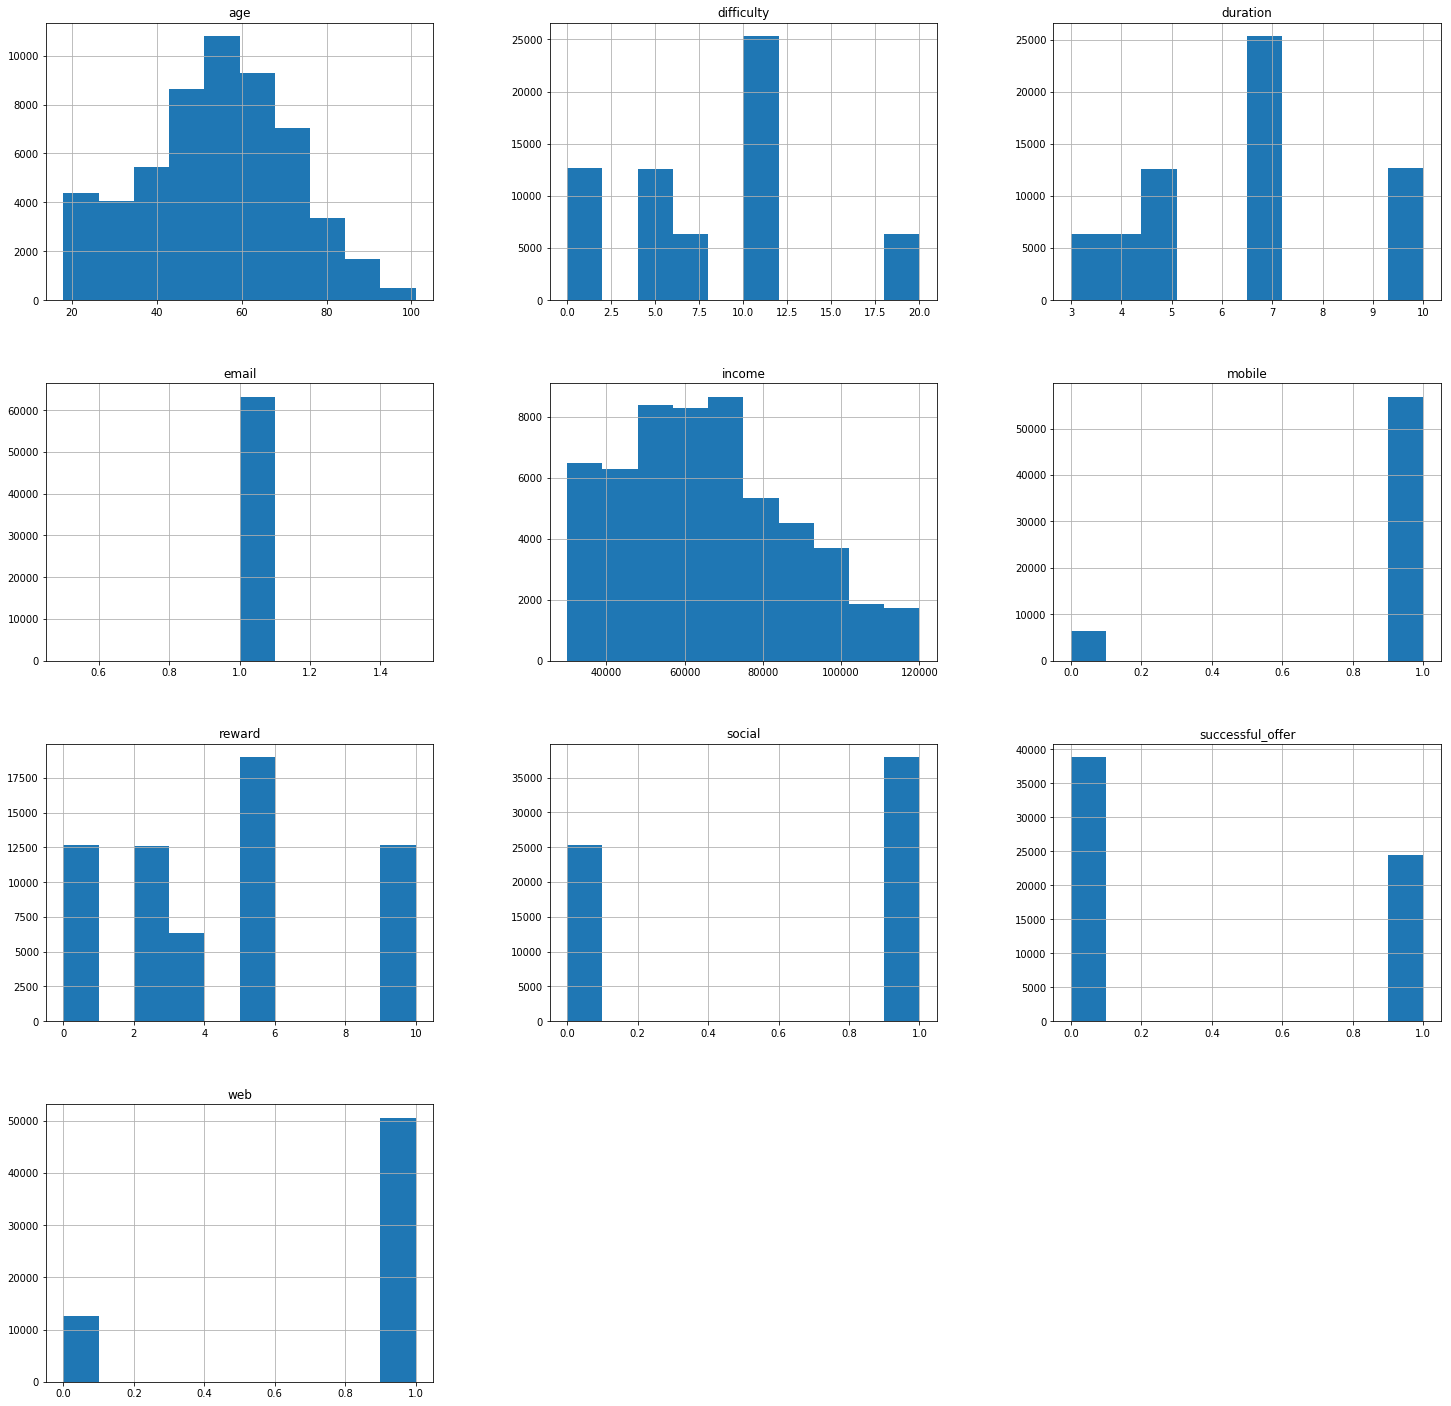

In [64]:
main_df.hist(figsize=(25, 25))

In [65]:
successful_df = main_df.query("successful_offer == 1")

In [66]:
successful_df.head(5)

,customer_id,offer_id,successful_offer,offer_type,reward,difficulty,duration,email,mobile,social,web,age,gender,income,became_member_on
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,5,1,1,1,1,33.0,M,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,2,10,10,1,1,1,1,33.0,M,72000.0,2017-04-21
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,discount,5,20,10,1,0,0,1,40.0,O,57000.0,2018-01-09
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,discount,3,7,7,1,1,1,1,40.0,O,57000.0,2018-01-09
10,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,bogo,5,5,7,1,1,0,1,40.0,O,57000.0,2018-01-09


Text(0,0.5,'Number of successful offers')

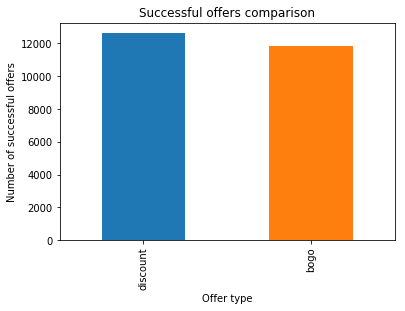

In [67]:
successful_df['offer_type'].value_counts().plot(kind="bar", title="test")
plt.title("Successful offers comparison")
plt.xlabel("Offer type")
plt.ylabel("Number of successful offers")

In [68]:
successful_df.offer_type.value_counts()

discount    12633
bogo        11827
Name: offer_type, dtype: int64

#### Observation about the graph above.

1. It seems that discount offers were used more than buy one get one.
2. Discount offer was successful 12633, on the other hand bogo was used 11827.

Let's have a look at unsuccessful offers.

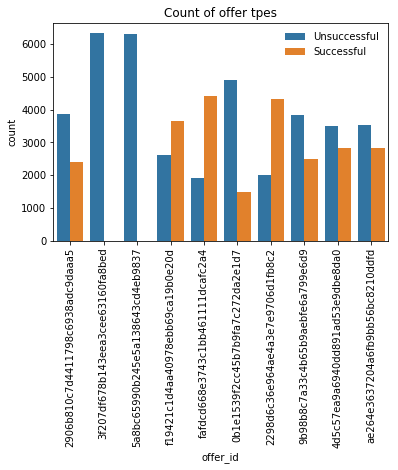

In [69]:
# Most unsuccessful offers by ID

sns.countplot(x='offer_id', hue='successful_offer', data=main_df);
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('Count of offer tpes')

plt.xticks(rotation=90);

### Observation: 

It seems that the most 2 unsuccessful offer ids are

1. 3f207df678b143eea3cee63160fa8bed
2. 5a8bc65990b245e5a138643cd4eb9837

Those ones didn't show any good results with the customers.

idea: Let's investigate them further.

In [70]:
unsuccessful_df = main_df.query('offer_id == "3f207df678b143eea3cee63160fa8bed" | offer_id == "5a8bc65990b245e5a138643cd4eb9837"')

In [71]:
unsuccessful_df.head()

,customer_id,offer_id,successful_offer,offer_type,reward,difficulty,duration,email,mobile,social,web,age,gender,income,became_member_on
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,4,1,1,0,1,33.0,M,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0,33.0,M,72000.0,2017-04-21
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,4,1,1,0,1,40.0,O,57000.0,2018-01-09
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0,40.0,O,57000.0,2018-01-09
12,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0,59.0,F,90000.0,2016-03-04


#### It seems that the offer_type informational is not much getting response. 
idea: Let's check the age and income of customers that recieved those offers.

Text(0.5,1,'Age distribution for the targeted customers for unsuccessful offers')

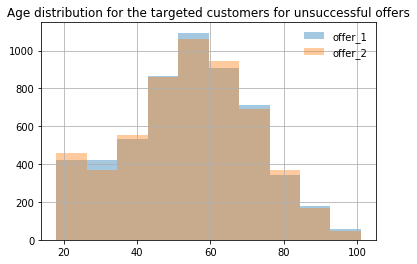

In [133]:
unsuccessful_df.groupby('offer_id')['age'].hist(alpha=0.4)
plt.legend(['offer_1','offer_2'],frameon=False)
plt.title('Age distribution for the targeted customers for unsuccessful offers')

Text(0.5,1,'Income distribution for the targeted customers for unsuccessful offers')

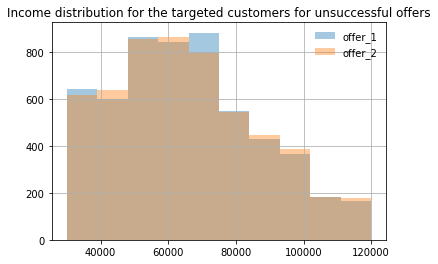

In [134]:
unsuccessful_df.groupby('offer_id')['income'].hist(alpha=0.4)
plt.legend(['offer_1','offer_2'],frameon=False)
plt.title('Income distribution for the targeted customers for unsuccessful offers')

Observation:

It seems that both of the offers were targeted to almost same features (age, income) However the difference is in the **channels** where those offers were published through.

I think it will be good to report this to the marketing team.

#### 2. Average Age of the people who used the offer BOGO?

& 

#### 3. Average income of the people who used the discount offer?

In [74]:
main_df.describe()

,successful_offer,reward,difficulty,duration,email,mobile,social,web,age,income
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,55222.000000,55222.000000
mean,0.386487,4.206232,7.711572,6.504819,1.0,0.899286,0.599529,0.799425,54.349969,65388.595125
std,0.486948,3.402914,5.541480,2.203565,0.0,0.300952,0.489998,0.400434,17.392733,21626.373809
min,0.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,18.000000,30000.000000
25%,0.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,42.000000,49000.000000
50%,0.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,55.000000,63000.000000
75%,1.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,66.000000,80000.000000
max,1.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,101.000000,120000.000000


In [75]:
# Fill in the missing values in age and income by mean value rounded.
main_df['income'] = main_df['income'].fillna((main_df['income'].mean()))
main_df['age'] = main_df['age'].fillna((main_df['age'].mean()))

In [76]:
main_df.describe()

,successful_offer,reward,difficulty,duration,email,mobile,social,web,age,income
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.386487,4.206232,7.711572,6.504819,1.0,0.899286,0.599529,0.799425,54.349969,65388.595125
std,0.486948,3.402914,5.541480,2.203565,0.0,0.300952,0.489998,0.400434,16.246609,20201.265865
min,0.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,18.000000,30000.000000
25%,0.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,45.000000,51000.000000
50%,0.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,54.349969,65388.595125
75%,1.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,64.000000,76000.000000
max,1.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,101.000000,120000.000000


Observation: 
    
- Filling in the missing values didn't move the std of the data much, which represents a good way to fill in the NaNs in this dataset.

In [77]:
def avg_col_value(df, column, offer_type_input, successful_offer_input):
    
    """
    Function to filter dataframe and get avg of column.
    
    Inputs:
        - df: Pandas DataFrame. (obj)
        - column: string of the column. (str)
        - offer_type_input: Offer type. (str)
        - successful_offer_input: 1 for successful_offer and 0 for not (int.)
    Outputs:
        - Return the average of the given column
    """
    
    df_success = df[(df.offer_type == offer_type_input) & (df.successful_offer == successful_offer_input)]
    return df_success[column].mean()

In [78]:
# Find avg age of the customers who used the offer BOGO and avg age for customers who used discount

avg_age_bogo = avg_col_value(df=main_df, column='age', offer_type_input="bogo", successful_offer_input=1)
avg_age_bogo 

55.983414205649829

In [79]:
avg_age_discount = avg_col_value(df=main_df, column='age', offer_type_input="discount", successful_offer_input=1)
avg_age_discount

55.415537133345659

Observation:

- It seems that the average age of the customer who used BOGO or discount offers are almost the same.

In [80]:
# Find avg income of the customers who used the offer BOGO and avg age for customers who used discount
avg_income_bogo = avg_col_value(df=main_df, column='income', offer_type_input="bogo", successful_offer_input=1)
avg_income_bogo

69848.45057803487

In [81]:
avg_income_discount = avg_col_value(df=main_df, column='income', offer_type_input="discount", successful_offer_input=1)
avg_income_discount

68011.384067824969

Text(0.5,1,'Offer type per Average income')

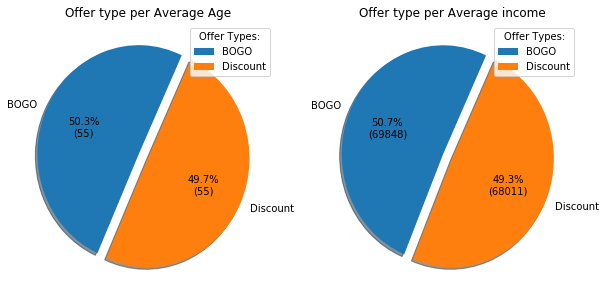

In [129]:
# Creating autocpt arguments
def func(pct, allvalues):
    """
    Function to the autopct argument, which will expand automatic percentage labeling by showing absolute values
    """
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)


# Define the sublots
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) 

# Plot1 details
y = np.array([avg_age_bogo, avg_age_discount])
mylabels = ["BOGO", "Discount"]
myexplode = [0.1, 0]
ax1.pie(y, labels = mylabels, explode = myexplode, shadow = True, startangle=65, autopct = lambda pct: func(pct, y))
ax1.legend(title = "Offer Types:")
ax1.set_title("Offer type per Average Age")

# Plot2 details
y = np.array([avg_income_bogo, avg_income_discount])
mylabels = ["BOGO", "Discount"]
myexplode = [0.1, 0]
ax2.pie(y, labels = mylabels, explode = myexplode, shadow = True, startangle=65, autopct = lambda pct: func(pct, y))
ax2.legend(title = "Offer Types:")
ax2.set_title("Offer type per Average income")

Observation: 

- It seems that the average income of the customer who used bogo is **>** average income of the customer who used discount.

------

## 4. Model Data

In [83]:
# Check point
# Save the dataframe
main_df.to_csv('main_df_backup.csv', index=False)

In [84]:
main_df.head()

,customer_id,offer_id,successful_offer,offer_type,reward,difficulty,duration,email,mobile,social,web,age,gender,income,became_member_on
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,discount,2,10,7,1,1,0,1,33.0,M,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,4,1,1,0,1,33.0,M,72000.0,2017-04-21
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0,33.0,M,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,5,1,1,1,1,33.0,M,72000.0,2017-04-21
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,2,10,10,1,1,1,1,33.0,M,72000.0,2017-04-21


#### Prepare and clean data for ML model implementation.

1. Check missing values.
2. Check cateogrial variables. If exists transfer them to dummy variables.

In [85]:
# Check missing values
main_df.isnull().sum()

customer_id            0
offer_id               0
successful_offer       0
offer_type             0
reward                 0
difficulty             0
duration               0
email                  0
mobile                 0
social                 0
web                    0
age                    0
gender              8066
income                 0
became_member_on    8066
dtype: int64

In [86]:
# Convert became_member_on to have only the year.
main_df['became_member_on'] = main_df.became_member_on.dt.year

In [87]:
# Fill in missing values with mode
main_df['became_member_on'].fillna(main_df['became_member_on'].mode()[0], inplace=True)

In [88]:
# Fill in missing values with mode
main_df['gender'].fillna(main_df['gender'].mode()[0], inplace=True)

In [89]:
# Check
main_df.isnull().sum()

customer_id         0
offer_id            0
successful_offer    0
offer_type          0
reward              0
difficulty          0
duration            0
email               0
mobile              0
social              0
web                 0
age                 0
gender              0
income              0
became_member_on    0
dtype: int64

In [90]:
# Convert gender values to numeric values. M = 1, F & O = 0
main_df['gender'] = main_df['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [91]:
main_df['gender'].value_counts()

1    39711
0    23577
Name: gender, dtype: int64

In [92]:
# Check
main_df.head()

,customer_id,offer_id,successful_offer,offer_type,reward,difficulty,duration,email,mobile,social,web,age,gender,income,became_member_on
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,discount,2,10,7,1,1,0,1,33.0,1,72000.0,2017.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,4,1,1,0,1,33.0,1,72000.0,2017.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,3,1,1,1,0,33.0,1,72000.0,2017.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,5,1,1,1,1,33.0,1,72000.0,2017.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,2,10,10,1,1,1,1,33.0,1,72000.0,2017.0


In [93]:
# Make offer type to be dummy variables.
main_df = pd.get_dummies(main_df, columns = ['offer_type'])

In [94]:
# Check offer type.
main_df.head()

,customer_id,offer_id,successful_offer,reward,difficulty,duration,email,mobile,social,web,age,gender,income,became_member_on,offer_type_bogo,offer_type_discount,offer_type_informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,2,10,7,1,1,0,1,33.0,1,72000.0,2017.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,0,4,1,1,0,1,33.0,1,72000.0,2017.0,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0,3,1,1,1,0,33.0,1,72000.0,2017.0,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,33.0,1,72000.0,2017.0,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,2,10,10,1,1,1,1,33.0,1,72000.0,2017.0,0,1,0


In [95]:
# Check data types
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 17 columns):
customer_id                 63288 non-null object
offer_id                    63288 non-null object
successful_offer            63288 non-null float64
reward                      63288 non-null int64
difficulty                  63288 non-null int64
duration                    63288 non-null int64
email                       63288 non-null int64
mobile                      63288 non-null int64
social                      63288 non-null int64
web                         63288 non-null int64
age                         63288 non-null float64
gender                      63288 non-null int64
income                      63288 non-null float64
became_member_on            63288 non-null float64
offer_type_bogo             63288 non-null uint8
offer_type_discount         63288 non-null uint8
offer_type_informational    63288 non-null uint8
dtypes: float64(4), int64(8), object(2), uint8(3

In [96]:
# Detect integer columns
int_cols = main_df.select_dtypes(exclude=['object', 'float64'])

# Loop through these columns and convert them to float
for col in int_cols.columns.values:
    main_df[col] = main_df[col].astype(float)

In [97]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 17 columns):
customer_id                 63288 non-null object
offer_id                    63288 non-null object
successful_offer            63288 non-null float64
reward                      63288 non-null float64
difficulty                  63288 non-null float64
duration                    63288 non-null float64
email                       63288 non-null float64
mobile                      63288 non-null float64
social                      63288 non-null float64
web                         63288 non-null float64
age                         63288 non-null float64
gender                      63288 non-null float64
income                      63288 non-null float64
became_member_on            63288 non-null float64
offer_type_bogo             63288 non-null float64
offer_type_discount         63288 non-null float64
offer_type_informational    63288 non-null float64
dtypes: float64(15), objec

### Models performance evaluation

- The F-score, also called the F1-score, is a measure of a model’s accuracy on a dataset. It is used to evaluate binary classification systems, which classify examples into ‘positive’ or ‘negative’, in our case accepted offer or not.

- The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall.

- Accuracy can be useful but does not take into account the subtleties of class imbalances, or differing costs of false negatives and false positives.


In [98]:
#Evaluation of models helper functions.

def evaluate_mode(y_test, y_test_preds, y_train, model_name, save_fig=0):
    
    """
    y_test: testing data from the reponse feature.
    y_test_preds: predicted data from the response feature.
    y_train: training data from the response feature.
    model_name: string which takes the model name and plugs it in the figures.
    save_fig: if 1 then it saves the plots, if 0 it doesn't save it.
    
    Return: None.
    
    """
    
    # Evaluation metrics
    
    # printing metrics of confusion matrix
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_preds))
    print("Precision:",metrics.precision_score(y_test, y_test_preds))
    print("Recall:",metrics.recall_score(y_test, y_test_preds))
    print("F1:",metrics.f1_score(y_test, y_test_preds))
    
    print("")
    # Compare some data using just printing the values.
    diff_df_lm = pd.DataFrame({
            'actual_values': np.array(y_test).flatten(),
            'predicted_values': y_test_preds.flatten()}).head(20)
    print("{} model predictions".format(model_name))
    print(diff_df_lm.head(20))
    print("")
    
    #Actual Vs Predicted for Linear Regression plot
    x = diff_df_lm.index
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, diff_df_lm.actual_values, width, label='Actual Values')
    rects2 = ax.bar(x + width/2, diff_df_lm.predicted_values, width, label='Predicted Values')
    ax.set_ylabel('Price')
    ax.set_title('Actual Vs Predicted for {}'.format(model_name))
    ax.set_xticks(x)
    ax.legend()
    fig.tight_layout()
    
    # To save the fig for documentation.
    if save_fig == 1:
        fig.savefig("Actual Vs Predicted for {}.png".format(model_name))
        plt.show()
    else:
        plt.show()
    

    
def comparison_of_distribution(y_test, y_test_preds, model_name, save_fig=0):
    """
    Function used to plot Scatter and distribution comparisons between the real response and the predicted one.
    
    y_test: testing data from the reponse feature.
    y_test_preds: predicted data from the response feature.
    model_name: string which takes the model name and plugs it in the figures.
    save_fig: if 1 then it saves the plots, if 0 it doesn't save it.
    
    Return: None.
    
    """
    #Comparison of distribution
    
    print("This is for model: {}".format(model_name))
    fig = plt.figure(figsize =(15, 5),dpi=100)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = plt.axes(aspect = 'equal')
    plt.subplot(121)
    plt.title('Scatter comparison', fontsize=12)
    plt.scatter(y_test, y_test_preds, color='blue')
    plt.xlabel('Real response', fontsize=14)
    plt.ylabel('Predicted response', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplot(122)
    sns.distplot(y_test_preds, hist=False,
                 kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted response'})
    sns.distplot(y_test, hist=False,
                 kde_kws={'color': 'r', 'lw': 2, 'label': 'Real response'})
    plt.title('Distribution comparison', fontsize=12)
    plt.ylabel('Probablity', fontsize=12)
    plt.xlabel('Successful offer', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['Predicted response', 'Real response'], prop={"size":12})
    
    # To save the fig for documentation.
    if save_fig == 1:
        fig.savefig("{} Distribution Comparison.png".format(model_name))
        plt.show()
    else:
        plt.show()

Observation: Since now we have all numerical values we can start in our model implementation.


- We want to build a model that predicts whether a customer will respond to an offer.
* As a baseline model, let's start with Logistic Regression:


In [99]:
# factors/features that influence the response
X = main_df.drop(columns=['successful_offer', 'customer_id'])

# Response/ What I want to predict
y = main_df['successful_offer']

In [100]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

In [101]:
X_train = X_train[:, 2:]
X_test = X_test[:, 2:]

In [130]:
# Define scorer from a performance metric
scorer = make_scorer(fbeta_score, beta=0.5)

## Logistic Regression

In [103]:
# Instantiate the model
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# Define params
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

# search for the best params
lr_random_search = RandomizedSearchCV(
    estimator = lr_clf,
    param_distributions = grid_params, 
    scoring=scorer,
    n_iter = 6,
    cv = 3,
    verbose=2, 
    random_state=42,
    n_jobs = 3)

# Fit
lr_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=   2.4s
[CV] ................................ penalty=l1, C=1.0, total=   1.9s
[CV] penalty=l2, C=1.0 ...............................................
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.7s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.7s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.7s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   21.9s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=6, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [104]:
# Predict
y_pred_lr_random_clf = lr_random_search.predict(X_test)

Accuracy: 0.729025122452
Precision: 0.661320085167
Recall: 0.628066864384
F1: 0.644264675379

Logistic Regression model predictions
    actual_values  predicted_values
0             0.0               0.0
1             0.0               0.0
2             1.0               0.0
3             0.0               1.0
4             0.0               1.0
5             1.0               0.0
6             0.0               1.0
7             0.0               0.0
8             0.0               1.0
9             0.0               0.0
10            0.0               1.0
11            0.0               0.0
12            0.0               0.0
13            0.0               0.0
14            1.0               0.0
15            0.0               0.0
16            1.0               1.0
17            1.0               1.0
18            0.0               1.0
19            1.0               1.0



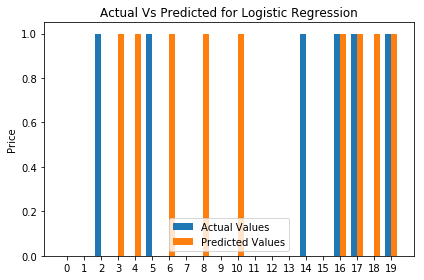

In [105]:
# Evaluate
evaluate_mode(y_test=y_test, y_test_preds=y_pred_lr_random_clf, y_train=y_train, model_name="Logistic Regression", save_fig=0)

This is for model: Logistic Regression


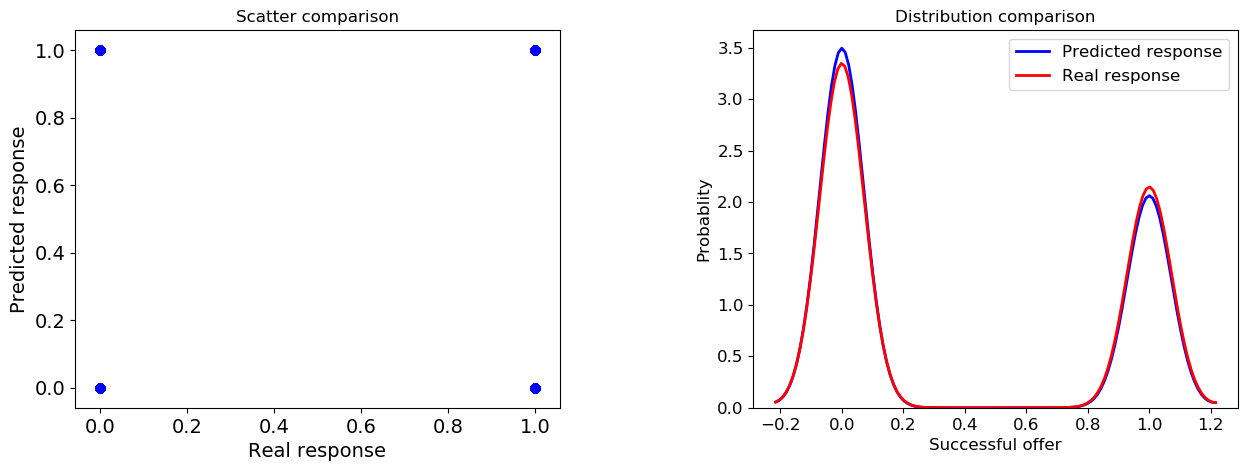

In [106]:
# Compare
comparison_of_distribution(y_test=y_test, y_test_preds=y_pred_lr_random_clf, model_name="Logistic Regression", save_fig=0)

### Observation about Logistic regression:


1. Logistic Regression seems to have an accuracy of ~ 73% and F1 score of 64%.

I think, we can do better than that by fine tuning params, but let's try Random Forest Classifier.

## Random Forest Classifier

In [107]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Define number of trees
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider
max_features = ['auto', 'sqrt']


# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features}

# Search for the best params.
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               random_state=42)

# fit the data to the classifier.
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [108]:
# Predict
y_test_preds_rf = rf_random.predict(X_test)

Accuracy: 0.743087375573
Precision: 0.679581447964
Recall: 0.647883526557
F1: 0.663354037267

Random Forest Classifier model predictions
    actual_values  predicted_values
0             0.0               0.0
1             0.0               0.0
2             1.0               0.0
3             0.0               1.0
4             0.0               1.0
5             1.0               0.0
6             0.0               0.0
7             0.0               0.0
8             0.0               0.0
9             0.0               0.0
10            0.0               0.0
11            0.0               0.0
12            0.0               0.0
13            0.0               0.0
14            1.0               0.0
15            0.0               0.0
16            1.0               1.0
17            1.0               1.0
18            0.0               0.0
19            1.0               0.0



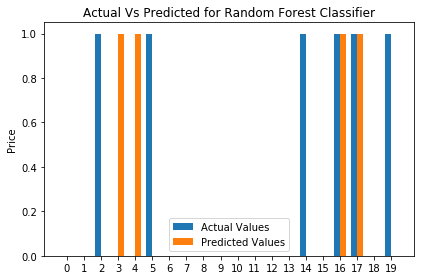

In [109]:
# Evaluate
evaluate_mode(y_test=y_test, y_test_preds=y_test_preds_rf, y_train=y_train, model_name="Random Forest Classifier", save_fig=0)

This is for model: Random Forest Classifier


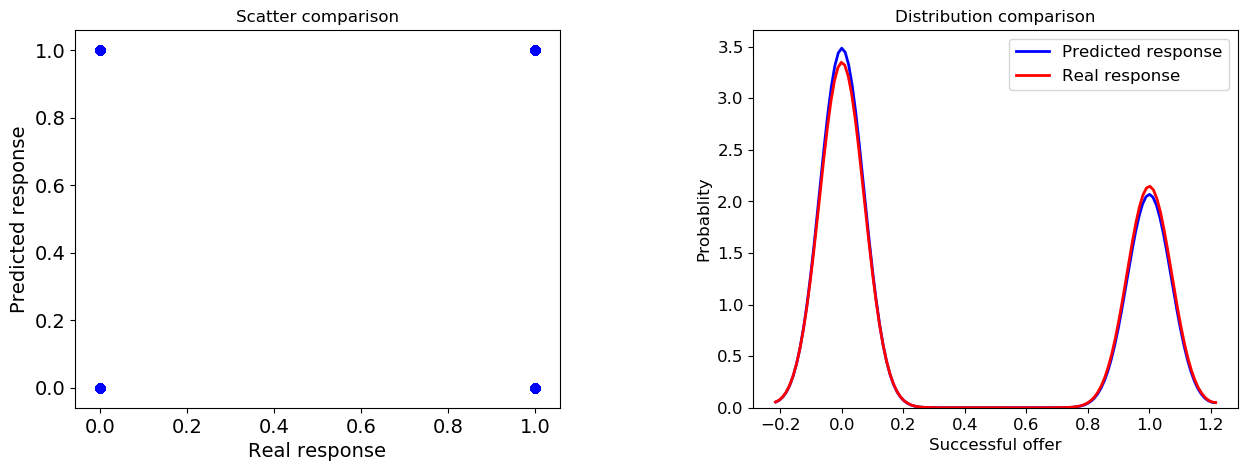

In [110]:
# Compare
comparison_of_distribution(y_test=y_test, y_test_preds=y_test_preds_rf, model_name="Random Forest Classifier", save_fig=1)

### Observation about Random Forest Classifier:


1. Random Forest Classifier seems to have an accuracy of ~ 73% and F1 score of 64%.
2. It seems it is not of a big difference from the Logisitic Regression.

Let's try Gradient boosting as it usually outperforms Random Forest.

## Gradient Boosting

In [111]:
# instantiate a gradient boosting classifier obj
gb_clf = GradientBoostingClassifier(random_state = 42)

# Define params.
n_estimators = [1, 10, 50, 100]
max_depth = [1, 2, 10, 20]
max_features = [4]
learning_rate = [1, .5, 0.25]


gbr_parameters = {'n_estimators': n_estimators, 
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'learning_rate': learning_rate}

# tune the classifer
gb_search = RandomizedSearchCV(estimator = gb_clf,
                               param_distributions = gbr_parameters,
                               random_state=42)

# Fit
gb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [1, 10, 50, 100], 'max_depth': [1, 2, 10, 20], 'max_features': [4], 'learning_rate': [1, 0.5, 0.25]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [112]:
# Predict
y_pred_gb_clf = gb_search.predict(X_test)

Accuracy: 0.765839785116
Precision: 0.702066902366
Recall: 0.69600970612
F1: 0.699025182778

Gradient Boosting Classifier model predictions
    actual_values  predicted_values
0             0.0               0.0
1             0.0               0.0
2             1.0               0.0
3             0.0               1.0
4             0.0               1.0
5             1.0               0.0
6             0.0               1.0
7             0.0               0.0
8             0.0               0.0
9             0.0               0.0
10            0.0               1.0
11            0.0               0.0
12            0.0               0.0
13            0.0               0.0
14            1.0               0.0
15            0.0               0.0
16            1.0               1.0
17            1.0               1.0
18            0.0               1.0
19            1.0               1.0



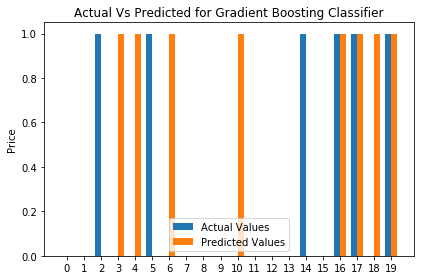

In [113]:
# Evaluate
evaluate_mode(y_test=y_test, y_test_preds=y_pred_gb_clf, y_train=y_train, model_name="Gradient Boosting Classifier", save_fig=1)

This is for model: Gradient Boosting Classifier


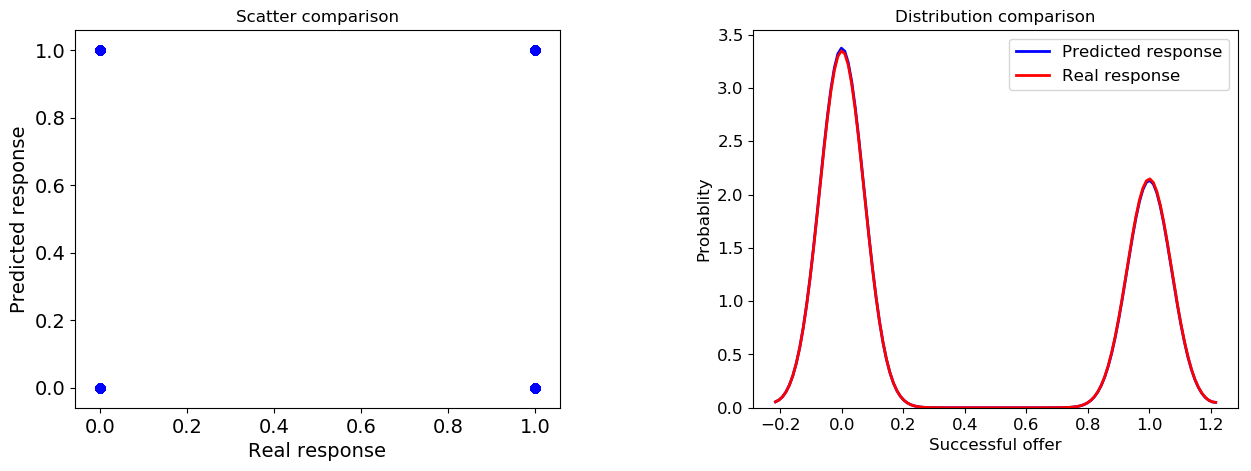

In [114]:
# Compare distribution
comparison_of_distribution(y_test=y_test, y_test_preds=y_pred_gb_clf, model_name="Gradient Boosting Classifier", save_fig=1)

### Observation about Gradient Boosting

1. As excpected, Gradient Boosting seems to have the highest accuracy of ~ 76.5% and F1 score of ~70%.


-----------

## 5. Results and Conclusions

In [119]:
# True positive rate, false positive rates
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_lr_random_clf)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_test_preds_rf)
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, y_pred_gb_clf)


lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
gb_auc = auc(gb_fpr, gb_tpr)

**Hint**: The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) 

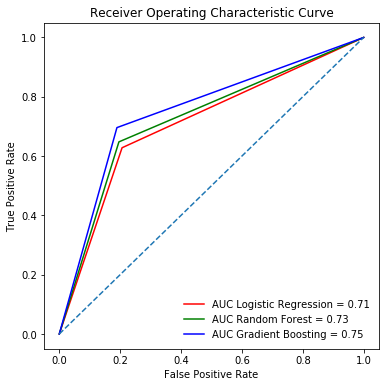

In [122]:
#Plot the auc 
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(lr_fpr, lr_tpr, color='red', label = 'AUC Logistic Regression = %0.2f' % lr_auc)
plt.plot(rf_fpr, rf_tpr, color='green', label = 'AUC Random Forest = %0.2f' % rf_auc)
plt.plot(gb_fpr, gb_tpr, color='blue', label='AUC Gradient Boosting = %0.2f' % gb_auc)
plt.legend(loc = 'lower right',frameon=False)

plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

As shown above, the Gradient Boosting is the best classifier with respect to our performance metric. However, I believe we can do better by tuning more parameters and probably collecting more data about the customers like their drinks preference.

- I find that project very motivating and require good analytics skills. The data structure is not that difficult to wrangle and work with, however, I feel I lack more "detailed/transparent" information about the data overview, meaning a low level illustration of each column especially in "transcript.json" file


- I think providing customer workflow/diagram (i.e. Offer received -> Offer viewed -> transaction -> ..) would very beneficial to be presented with such dataset. It will save a lot of time for the data scientist and analytics team figuring out which event is occurred/can come before which one

####  Conclusion 1
- According to the analytics, we find that most successful offers are discounts with around 12500 offers viewed and responded to, Buy one get one comes in second place with approx. 11800 interactions.

- On the other hand, those offer IDs **3f207df678b143eea3cee63160fa8bed**, **5a8bc65990b245e5a138643cd4eb9837** are the most unsuccessful ones, they are of type Informational. Those ones didn't show any good results with the customers.
It seems that both of the offers were targeted to almost the same customers’ features (age, income) However the difference is in the channels where those offers were published through.

- I think it will be good to report this to the marketing team. *


####  Conclusion 2

- The average age using the offers are almost the same, so there is nothing more to discuss further at this point or to set this up as a metric.
- It seems that the average income of the customer who used bogo is > average income of the customer who used the discount offers.


####  Conclusion 3
- Finally, three supervised machine learning models were implemented to be able to predict whether a customer will respond to an offer. Accuracy and F1 score were used to measure the models performance in the classification problem.

- **Logistic Regression** showed accuracy of 72.9 % The distribution showed that the predicted response mainly is good at predicting when the customer will decline an offer.

- Secondly, the **Random forest classifier** was implemented and showed an accuracy of 74.3% which is not a big difference.

- However, the **Gradient boosting algorithm** showed a better performance of 76.5%.

- **Receiver operating characteristic curve** was implemented to show the difference between the models. It is obvious that the Gradient tends to be the highest value, getting close to 1.

- As shown above, the Gradient Boosting is the best classifier with respect to our performance metric. However, I believe we can do better by tuning more parameters and probably collecting more data about the customers like their drinks preference.


## 6. Deploy via Medium.

#### Medium Link: 

#### Sources

1. https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic
3. https://en.wikipedia.org/wiki/Logistic_regression
4. https://en.wikipedia.org/wiki/Random_forest
5. https://deepai.org/machine-learning-glossary-and-terms/f-score